In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

In [92]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/yambo_module',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [ ]:
# RunRules for m100
nodes = 16 # 16
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_PrExIn',
                memory='240GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.YamboCalculator(rr)
code.global_options()

# Optical absorption of the AGSL5

We study the optical absorption spectrum of the AGSL5.

## IP absorption on top of the DFT analysis

We study the absorption spectrum on top of the DFT analysis in function of the k-points sampling.

In [76]:
kvalues = [10,15,20,25]

In [77]:
RandGvec = 100
RandQpts = 5e6

dft_gap = 0.3

energy_range = [0,10] # eV
damping = [0.1,0.1] # eV
BLongDir = [1.0,0.0,0.0]

study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kvalues:
    run_dir = 'MB_analysis/kpoints_%sx%s-nbnds_35'%(k,2*k)
    inp = I.YamboInput('yambo -r -o b -k IP',folder=run_dir)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=RandQpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec)
    inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
    inp.set_array_variables(BLongDir=BLongDir)
    idd = 'abs-ip-xPol-kpoints_%sx%s'%(k,2*k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)


Initialize a Dataset with 2 parallel tasks


In [78]:
#study.runs[0]

In [79]:
results = study.run()

Run the selection [0, 1, 2, 3] with the parallel task_groups [[0, 1], [2, 3]] 

Run the task [0, 1] 
delete job_out script: MB_analysis/kpoints_10x20-nbnds_35/job_abs-ip-xPol-kpoints_10x20.out
delete folder: MB_analysis/kpoints_10x20-nbnds_35/abs-ip-xPol-kpoints_10x20
run command: mpirun -np 16 yambo -F abs-ip-xPol-kpoints_10x20.in -J abs-ip-xPol-kpoints_10x20 -C abs-ip-xPol-kpoints_10x20
slurm submit:  cd MB_analysis/kpoints_10x20-nbnds_35 ; sbatch job_abs-ip-xPol-kpoints_10x20.sh
delete job_out script: MB_analysis/kpoints_15x30-nbnds_35/job_abs-ip-xPol-kpoints_15x30.outcomputation abs-ip-xPol-kpoints_10x20 is running...

delete folder: MB_analysis/kpoints_15x30-nbnds_35/abs-ip-xPol-kpoints_15x30
run command: mpirun -np 16 yambo -F abs-ip-xPol-kpoints_15x30.in -J abs-ip-xPol-kpoints_15x30 -C abs-ip-xPol-kpoints_15x30
slurm submit:  cd MB_analysis/kpoints_15x30-nbnds_35 ; sbatch job_abs-ip-xPol-kpoints_15x30.sh
computation abs-ip-xPol-kpoints_15x30 is running...
computation abs-ip-xPol

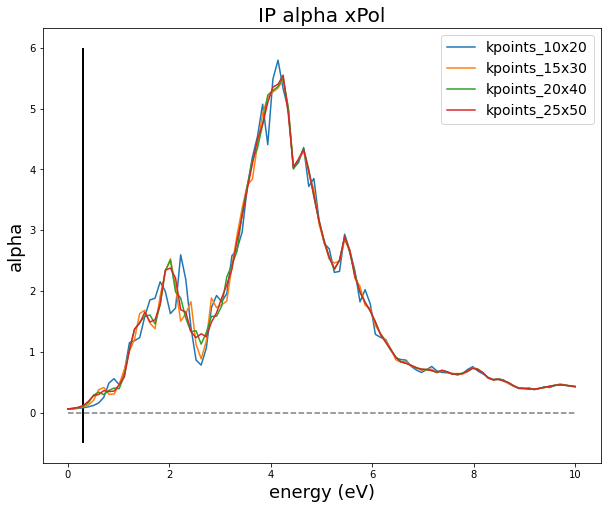

In [80]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,k in enumerate(kvalues):
    data = results[ind].data['alpha_q1_IP']
    energy = data['energy']
    alpha_im = data['alpha_imag']
    ax.plot(energy,alpha_im,label='kpoints_%sx%s'%(k,2*k)) 
ax.vlines(dft_gap,-0.5,6,linestyles='-',color='black',linewidth=2)
ax.hlines(0,xmin=0,xmax=energy[-1],linestyles='--',color='gray')
ax.set_ylabel('alpha',size=18)
ax.set_xlabel('energy (eV)',size=18)
ax.set_title('IP alpha xPol',size=20)
ax.legend(fontsize=14)

In the same way we can compute the polarizability due to a field polarized along the y direction

In [81]:
RandGvec = 100
RandQpts = 5e6

dft_gap = 0.3

energy_range = [0,6] # eV
damping = [0.07,0.07] # eV
BLongDir = [0.0,1.0,0.0]

study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kvalues:
    run_dir = 'MB_analysis/kpoints_%sx%s-nbnds_35'%(k,2*k)
    inp = I.YamboInput('yambo -r -o b -k IP',folder=run_dir)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=RandQpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec)
    inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
    inp.set_array_variables(BLongDir=BLongDir)
    idd = 'abs-ip-yPol-kpoints_%sx%s'%(k,2*k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)


Initialize a Dataset with 2 parallel tasks


In [82]:
#study.runs[0]

In [83]:
results = study.run()

Run the selection [0, 1, 2, 3] with the parallel task_groups [[0, 1], [2, 3]] 

Run the task [0, 1] 
delete job_out script: MB_analysis/kpoints_10x20-nbnds_35/job_abs-ip-yPol-kpoints_10x20.out
delete folder: MB_analysis/kpoints_10x20-nbnds_35/abs-ip-yPol-kpoints_10x20
run command: mpirun -np 16 yambo -F abs-ip-yPol-kpoints_10x20.in -J abs-ip-yPol-kpoints_10x20 -C abs-ip-yPol-kpoints_10x20
slurm submit:  cd MB_analysis/kpoints_10x20-nbnds_35 ; sbatch job_abs-ip-yPol-kpoints_10x20.sh
delete job_out script: MB_analysis/kpoints_15x30-nbnds_35/job_abs-ip-yPol-kpoints_15x30.out
computation abs-ip-yPol-kpoints_10x20 is running...
delete folder: MB_analysis/kpoints_15x30-nbnds_35/abs-ip-yPol-kpoints_15x30
run command: mpirun -np 16 yambo -F abs-ip-yPol-kpoints_15x30.in -J abs-ip-yPol-kpoints_15x30 -C abs-ip-yPol-kpoints_15x30
slurm submit:  cd MB_analysis/kpoints_15x30-nbnds_35 ; sbatch job_abs-ip-yPol-kpoints_15x30.sh
computation abs-ip-yPol-kpoints_15x30 is running...
computation abs-ip-yPol

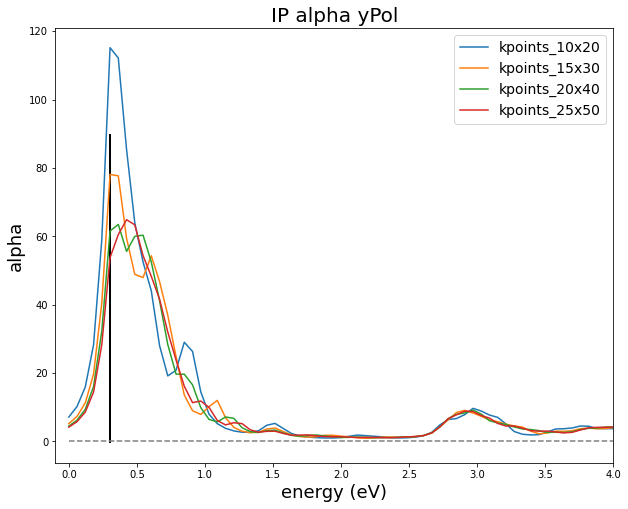

In [84]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,k in enumerate(kvalues):
    data = results[ind].data['alpha_q1_IP']
    energy = data['energy']
    alpha_im = data['alpha_imag']
    ax.plot(energy,alpha_im,label='kpoints_%sx%s'%(k,2*k)) 
ax.vlines(dft_gap,-0.5,90,linestyles='-',color='black',linewidth=2)
ax.hlines(0,xmin=0,xmax=energy[-1],linestyles='--',color='gray')
ax.set_xlim(-0.1,4)
ax.set_ylabel('alpha',size=18)
ax.set_xlabel('energy (eV)',size=18)
ax.set_title('IP alpha yPol',size=20)
ax.legend(fontsize=14)

## IP absorption with local fields

We compute the polarizability along the y direction including the kernel Hartree that accounts for the local field effects

In [114]:
kvalues = [10]

In [115]:
RandGvec = 100
RandQpts = 5e6

dft_gap = 0.3

energy_range = [0,6] # eV
energy_step = 1000
damping = [0.07,0.07] # eV
BSEBands = [20,35]
BLongDir = [0.0,1.0,0.0]

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kvalues:
    run_dir = 'MB_analysis/kpoints_%sx%s-nbnds_35'%(k,2*k)
    inp = I.YamboInput('yambo -r -o b -k hartree -y d',folder=run_dir)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=RandQpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec)
    inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
    inp.set_array_variables(BEnSteps=energy_step,BSEBands=BSEBands)
    inp.set_array_variables(BLongDir=BLongDir)
    inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')   
    idd = 'abs-hartree-yPol-kpoints_%sx%s'%(k,2*k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)


Initialize a Dataset with 1 parallel tasks


In [121]:
#study.runs[0]

In [117]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of abs-hartree-yPol-kpoints_10x20
Task [0] ended 
 


In [126]:
#results[0].data['alpha_q1_diago_bse']

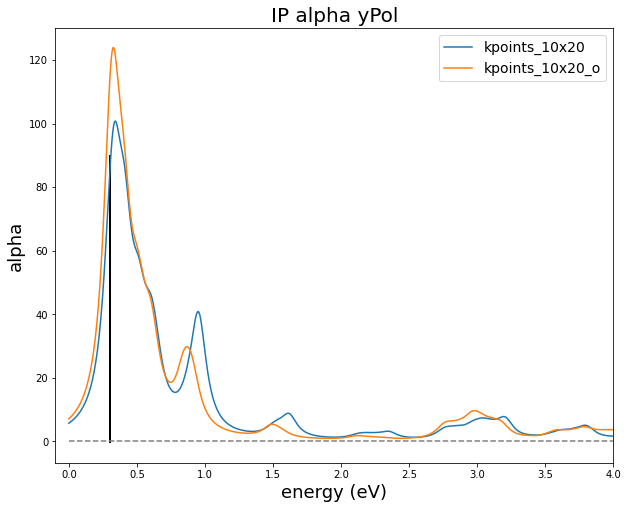

In [128]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,k in enumerate(kvalues):
    data = results[ind].data['alpha_q1_diago_bse']
    energy = data['energy']
    alpha_im = data['eps_imag']
    alpha_o_im = data['eps_o_imag']
    ax.plot(energy,alpha_im,label='kpoints_%sx%s'%(k,2*k)) 
    ax.plot(energy,alpha_o_im,label='kpoints_%sx%s_o'%(k,2*k)) 
ax.vlines(dft_gap,-0.5,90,linestyles='-',color='black',linewidth=2)
ax.hlines(0,xmin=0,xmax=energy[-1],linestyles='--',color='gray')
ax.set_xlim(-0.1,4)
ax.set_ylabel('alpha',size=18)
ax.set_xlabel('energy (eV)',size=18)
ax.set_title('IP alpha yPol',size=20)
ax.legend(fontsize=14)